# Portfolio return analysis

In [1]:
import sys
sys.path.append('/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/codes/')
from module.strategy import Linear_shrink_tbn,\
                            Linear_shrink_ledoit,\
                            Nonlinear_shrink_ledoit,\
                            Shrink_0,\
                            Shrink_50,\
                            Shrink_100,\
                            Shrink_0_tbn,\
                            Shrink_50_tbn,\
                            Shrink_100_tbn
from itertools import chain
import nonlinshrink as nls
from sklearn.covariance import LedoitWolf
from sklearn.covariance import OAS
from scipy.stats import moment
import numpy as np
import pandas as pd
from module.backtesting_old import vectorized_backtesting
from module.data_handler import data_handler
import matplotlib.pyplot as plt
import arch.data.frenchdata
from arch.bootstrap import CircularBlockBootstrap
from datetime import datetime

## RL performance

In [7]:
class shrink_fixed_alpha_identity(vectorized_backtesting):
    '''
    Shrink sample covariance matrix a fixed percent to identity matrix
    '''
    
    def __init__(self):
        super().__init__()
        self.alpha_mapping = RL_identity_df['action']
        self.stock_num = self.covariance_aggregate.shape[1]

    def get_portfolio(self, year):
        sample_covariance_matrix = self.stocks_returns_aggregate.loc[year-1: year - 1].cov()
        covariance_shrunk = self.get_shrank_cov(covariance_matrix=sample_covariance_matrix.values,\
                                                shrink_target=np.identity(self.stock_num),\
                                                a=self.alpha_mapping[year])
        portfolio = self.get_GMVP(covariance_matrix = covariance_shrunk)
        
        return portfolio

In [9]:
class shrink_fixed_alpha_tbn(vectorized_backtesting):
    '''
    Shrink sample covariance matrix a fixed percent to TBN
    '''
    def __init__(self):
        super().__init__()
        self.alpha_mapping = dqn_perfromance_df['action']

    def get_portfolio(self, year):
        covariance_shrunk = self.get_shrank_cov(correlation_matrix=self.correlation_aggregate.loc[year - 1].values,\
                                                shrink_target=self.tbn_combined.loc[year - 1].values,\
                                                volatility_vector=self.volatility_aggregate.loc[year - 1].values,
                                                a=self.alpha_mapping[year])
        portfolio = self.get_GMVP(covariance_matrix = covariance_shrunk)
        return portfolio

In [12]:
# RL on TBN
year_range = np.arange(2001, 2017+1)
file_path = '/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/output/table/DQN_performance.csv'
dqn_perfromance_df = pd.read_csv(file_path, header=0)
rl_alpha_list = dqn_perfromance_df['action']
dqn_perfromance_df.index = year_range

In [28]:
rl_agent_list = [shrink_fixed_alpha_tbn() for _ in year_range]
rl_return_list = [strategy.get_portfolio_daily_return(start=year, end=year) for strategy, year in zip(rl_agent_list, year_range)]
rl_SR_list = [strategy.get_sharpe_ratio() for strategy in rl_agent_list]
rl_date_list = [strategy.stock_date[strategy.stock_date.slice_indexer(start=str(year),end=str(year))] for strategy, year in zip(rl_agent_list, year_range)]

In [13]:
# RL on identity matrix
year_range = np.arange(2001, 2017+1)
file_path = '/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/output/data/RL_identity_ts.csv'
RL_identity_df = pd.read_csv(file_path, header=0)
rl_alpha_list = RL_identity_df['action']
RL_identity_df.index = year_range

In [64]:
RL_identity_agent_list = [shrink_fixed_alpha_identity() for _ in year_range]
RL_identity_return_list = [strategy.get_portfolio_daily_return(start=year, end=year) for strategy, year in zip(RL_identity_agent_list, year_range)]
RL_identity_SR_list = [strategy.get_sharpe_ratio() for strategy in RL_identity_agent_list]

## Benchmark performance

In [10]:
class Linear_shrink_ledoit_new(vectorized_backtesting):
    '''
    Linear shrinkage method(ledoit) that shrink to identity matrix
    '''
    def get_portfolio(self, year):
        covariance_shrunk = LedoitWolf().fit(self.stocks_returns_aggregate.loc[(year - 5):(year - 1)]).covariance_
        portfolio = self.get_GMVP(covariance_matrix=  covariance_shrunk)
        return portfolio

In [8]:
# Linear identity
year_range = np.arange(2001, 2017+1)
agent_list = [Linear_shrink_ledoit_new() for _ in year_range]
Linear_shrink_ledoit_return_list = [strategy.get_portfolio_daily_return(start=year, end=year) for strategy, year in zip(agent_list, year_range)]
Linear_shrink_ledoit_sr_list = [strategy.get_sharpe_ratio() for strategy in agent_list]
Linear_shrink_ledoit_date_list = [strategy.stock_date[strategy.stock_date.slice_indexer(start=str(year),end=str(year))] for strategy, year in zip(agent_list, year_range)]

In [18]:
# Non Linear identity
year_range = np.arange(2001, 2017+1)
agent_list = [Nonlinear_shrink_ledoit() for _ in year_range]
Nonlinear_shrink_ledoit_return_list = [strategy.get_portfolio_daily_return(start=year, end=year) for strategy, year in zip(agent_list, year_range)]
Nonlinear_shrink_ledoit_sr_list = [strategy.get_sharpe_ratio() for strategy in agent_list]
Nonlinear_shrink_ledoit_date_list = [strategy.stock_date[strategy.stock_date.slice_indexer(start=str(year),end=str(year))] for strategy, year in zip(agent_list, year_range)]

In [22]:
# Linear TBN
year_range = np.arange(2001, 2017+1)
agent_list = [Linear_shrink_tbn() for _ in year_range]
Linear_shrink_tbn_return_list = [strategy.get_portfolio_daily_return(start=year, end=year) for strategy, year in zip(agent_list, year_range)]
Linear_shrink_tbn_sr_list = [strategy.get_sharpe_ratio() for strategy in agent_list]
Linear_shrink_tbn_date_list = [strategy.stock_date[strategy.stock_date.slice_indexer(start=str(year),end=str(year))] for strategy, year in zip(agent_list, year_range)]

In [11]:
# 0 pct identity
year_range = np.arange(2001, 2017+1)
agent_list = [Shrink_0() for _ in year_range]
Shrink_0_return_list = [strategy.get_portfolio_daily_return(start=year, end=year) for strategy, year in zip(agent_list, year_range)]
Shrink_0_sr_list = [strategy.get_sharpe_ratio() for strategy in agent_list]
Shrink_0_date_list = [strategy.stock_date[strategy.stock_date.slice_indexer(start=str(year),end=str(year))] for strategy, year in zip(agent_list, year_range)]


In [2]:
# 50 pct identity
year_range = np.arange(2001, 2017+1)
agent_list = [Shrink_50() for _ in year_range]
Shrink_50_return_list = [strategy.get_portfolio_daily_return(start=year, end=year) for strategy, year in zip(agent_list, year_range)]
Shrink_50_sr_list = [strategy.get_sharpe_ratio() for strategy in agent_list]
Shrink_50_date_list = [strategy.stock_date[strategy.stock_date.slice_indexer(start=str(year),end=str(year))] for strategy, year in zip(agent_list, year_range)]


In [3]:
# 100 pct identity
year_range = np.arange(2001, 2017+1)
agent_list = [Shrink_100() for _ in year_range]
Shrink_100_return_list = [strategy.get_portfolio_daily_return(start=year, end=year) for strategy, year in zip(agent_list, year_range)]
Shrink_100_sr_list = [strategy.get_sharpe_ratio() for strategy in agent_list]
Shrink_100_date_list = [strategy.stock_date[strategy.stock_date.slice_indexer(start=str(year),end=str(year))] for strategy, year in zip(agent_list, year_range)]


In [8]:
# 0 pct TBN
year_range = np.arange(2001, 2017+1)
agent_list = [Shrink_0_tbn() for _ in year_range]
Shrink_0_tbn_return_list = [strategy.get_portfolio_daily_return(start=year, end=year) for strategy, year in zip(agent_list, year_range)]
Shrink_0_tbn_sr_list = [strategy.get_sharpe_ratio() for strategy in agent_list]
Shrink_0_tbn_date_list = [strategy.stock_date[strategy.stock_date.slice_indexer(start=str(year),end=str(year))] for strategy, year in zip(agent_list, year_range)]


In [14]:
# 50 pct identity
year_range = np.arange(2001, 2017+1)
agent_list = [Shrink_50_tbn() for _ in year_range]
Shrink_50_tbn_return_list = [strategy.get_portfolio_daily_return(start=year, end=year) for strategy, year in zip(agent_list, year_range)]
Shrink_50_tbn_sr_list = [strategy.get_sharpe_ratio() for strategy in agent_list]
Shrink_50_tbn_date_list = [strategy.stock_date[strategy.stock_date.slice_indexer(start=str(year),end=str(year))] for strategy, year in zip(agent_list, year_range)]


In [16]:
# 100 pct identity
year_range = np.arange(2001, 2017+1)
agent_list = [Shrink_100_tbn() for _ in year_range]
Shrink_100_tbn_return_list = [strategy.get_portfolio_daily_return(start=year, end=year) for strategy, year in zip(agent_list, year_range)]
Shrink_100_tbn_sr_list = [strategy.get_sharpe_ratio() for strategy in agent_list]
Shrink_100_tbn_date_list = [strategy.stock_date[strategy.stock_date.slice_indexer(start=str(year),end=str(year))] for strategy, year in zip(agent_list, year_range)]


# Aggregation

In [69]:
return_time_series_dict = {'0_pct_identity': np.hstack(Shrink_0_return_list),
                           '50_pct_identity': np.hstack(Shrink_50_return_list),
                           '100_pct_identity': np.hstack(Shrink_100_return_list),
                           '0_pct_TBN':np.hstack(Shrink_0_tbn_return_list),
                           '50_pct_TBN':np.hstack(Shrink_50_tbn_return_list),
                           '100_pct_TBN':np.hstack(Shrink_100_tbn_return_list),
                           'Ledoit_linear_identity':np.hstack(Linear_shrink_ledoit_return_list),
                           'Ledoit_nonlinear_identity':np.hstack(Nonlinear_shrink_ledoit_return_list),
                           'Ledoit_linear_TBN':np.hstack(Linear_shrink_tbn_return_list),
                           'RL_TBN':np.hstack(rl_return_list),
                           'RL_identity':np.hstack(RL_identity_return_list)
}
return_time_series_df = pd.DataFrame(return_time_series_dict, index=return_date_series)

In [71]:
return_time_series_df.to_csv('/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/output/data/strategies_return_ts.csv')

In [73]:
SR_dict = {'0_pct_identity': np.mean(Shrink_0_sr_list),
            '50_pct_identity': np.mean(Shrink_50_sr_list),
            '100_pct_identity': np.mean(Shrink_100_sr_list),
            '0_pct_TBN':np.mean(Shrink_0_tbn_sr_list),
            '50_pct_TBN':np.mean(Shrink_50_tbn_sr_list),
            '100_pct_TBN':np.mean(Shrink_100_tbn_sr_list),
            'Ledoit_linear_identity':np.mean(Linear_shrink_ledoit_sr_list),
            'Ledoit_nonlinear_identity':np.mean(Nonlinear_shrink_ledoit_sr_list),
            'Ledoit_linear_TBN':np.mean(Linear_shrink_tbn_sr_list),
            'RL_TBN':np.mean(rl_SR_list),
            'RL_identity':np.mean(RL_identity_SR_list)
}
SR_df = pd.DataFrame(SR_dict, index=['SR'])

In [23]:
SR_dict = {'0_pct_identity': 0.577854,
            '50_pct_identity': 0.915915,
            '100_pct_identity': 0.934393,
            '0_pct_TBN': 0.577854,
            '50_pct_TBN': 0.706204,
            '100_pct_TBN': 0.806761,
            'Ledoit_linear_identity': 0.622106,
            'Ledoit_nonlinear_identity': 0.593815,
            'Ledoit_linear_TBN': 0.598130,
            'RL_TBN': 0.706204,
            'RL_identity': 0.864733
}
SR_df = pd.DataFrame(SR_dict, index=['SR'])

In [36]:
TO_dict = {'0_pct_identity': 0.845,
            '50_pct_identity': 0.067,
            '100_pct_identity': 0.000,
            '0_pct_TBN': 0.845,
            '50_pct_TBN': 0.410,
            '100_pct_TBN': 0.167,
            'Ledoit_linear_identity': 0.726,
            'Ledoit_nonlinear_identity': 0.717,
            'Ledoit_linear_TBN': 0.770,
            'RL_TBN': 0.485,
            'RL_identity': 0.294
}
TO_vec = pd.Series(TO_dict)
SR_vec = SR_df.squeeze()

In [36]:
SR_df.T.to_latex('/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/output/new_sr_table.tex', float_format="%.5f")

# Statistical Test
## Two sample T-test

In [6]:
from scipy import stats as st

portf_ret_ts = pd.read_csv('/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/output/strategies_return_ts.csv',
                        index_col=0,
                        parse_dates=True)

In [29]:
t_test_dict = {'0_pct_identity': [st.ttest_ind(a = portf_ret_ts['0_pct_identity'], b = coldata).pvalue for (colname, coldata) in portf_ret_ts.iteritems()],
            'Ledoit_linear_identity': [st.ttest_ind(a = portf_ret_ts['Ledoit_linear_identity'], b = coldata).pvalue for (colname, coldata) in portf_ret_ts.iteritems()],
            'Ledoit_linear_TBN': [st.ttest_ind(a = portf_ret_ts['Ledoit_linear_TBN'], b = coldata).pvalue for (colname, coldata) in portf_ret_ts.iteritems()]
}
t_test_df = pd.DataFrame(t_test_dict, index=['0_pct_identity', '50_pct_identity', '100_pct_identity', '0_pct_TBN', '50_pct_TBN', '100_pct_TBN', 'Ledoit_linear_identity', 'Ledoit_nonlinear_identity', 'Ledoit_linear_TBN', 'RL_TBN', 'RL_identity'])

In [30]:
t_test_df

,0_pct_identity,Ledoit_linear_identity,Ledoit_linear_TBN
0_pct_identity,1.000000,0.964104,0.995637
50_pct_identity,0.541757,0.567800,0.536623
100_pct_identity,0.460398,0.483250,0.455583
0_pct_TBN,1.000000,0.964104,0.995637
50_pct_TBN,0.941173,0.977062,0.936469
100_pct_TBN,0.715984,0.746943,0.710814
Ledoit_linear_identity,0.964104,1.000000,0.959534
Ledoit_nonlinear_identity,0.980487,0.944352,0.984766
Ledoit_linear_TBN,0.995637,0.959534,1.000000
RL_TBN,0.941173,0.977062,0.936469


In [33]:
t_test_df.to_latex('/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/output/t_test.tex', float_format="%.3f")

## Bootstrap inference for Sharpe ratio

### data 

In [2]:
from datetime import datetime

file = '/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/output/strategies_return_ts.csv'
portfolio_return_df = pd.read_csv(file, index_col=0, parse_dates=True)

file_path = '/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/data/Data/F-F_Research_Data_Factors_daily.csv'
date_format = '%Y%m%d' # Y for year, m for month, d for day
rf = pd.read_csv(file_path,  header=0, usecols=[0, 4], index_col=[0], engine='c').dropna()
rf_date = pd.Index([datetime.strptime(str(x), date_format) for x in rf.index]) # convert index to date object
rf.index = rf_date

subset_index = portfolio_return_df.index
rf = rf.loc[subset_index]

rf = rf / 100
portfolio_excess_return_df = portfolio_return_df - rf.values

In [ ]:
r_i = portfolio_excess_return_df.values[:,0]
r_n = np.hstack(rf.values)

### Bootstrap block

In [127]:

import numpy as np
import pandas as pd
entropy = [877788388, 418255226, 989657335, 69307515]
seed = np.random.default_rng(entropy)
bs = CircularBlockBootstrap(10, np.arange(100), seed=seed)
results = bs.apply(sharpe_ratio, 2)


In [126]:
sharpe_ratio(bs.pos_data[0])

mu       452.400000
sigma     83.355384
SR         5.427364
dtype: float64

### Compute  $\hat{\Psi}^{*}$

\begin{align}
    \hat{\Psi}^{*}&=\frac{1}{l} \sum_{j=1}^{l} \zeta_{j} \zeta_{j}^{\prime}\\
\zeta_{j}&=\frac{1}{\sqrt{b}} \sum_{t=1}^{b} y_{(j-1) b+t}^{*} \quad t=1, \ldots, l\\
y_{t}^{*}&=\left(r_{t i}^{*}-\hat{\mu}_{i}^{*}, r_{t n}^{*}-\hat{\mu}_{n}^{*}, r_{t i}^{* 2}-\hat{\gamma}_{i}^{*}, r_{t n}^{* 2}-\hat{\gamma}_{n}^{*}\right) \quad t=1, \ldots, T
\end{align}

where $\gamma_{i}=E\left(r_{1 i}^{2}\right) \text { and } \gamma_{n}=E\left(r_{1 n}^{2}\right)$.

In [78]:
def get_y(r_i: np.array, r_n: np.array) -> np.array:
    r_i_square = r_i ** 2
    r_n_square = r_n ** 2
    mu_i = np.mean(r_i)
    mu_n = np.mean(r_n)
    gamma_i = np.mean(r_i_square)
    gamma_n = np.mean(r_n_square)
    y = np.array([r_i - mu_i, r_n - mu_n, r_i_square - gamma_i, r_n_square - gamma_n])

    return y

In [180]:
def get_zeta_j(y:np.array, b:int) -> np.array:
    zeta = np.sum(y, axis=1) / np.sqrt(b)

    return zeta

In [99]:
def get_phi_j(zeta:np.array) -> float:
    phi_j = zeta @ zeta

    return phi_j

In [192]:
def get_phi(r_i, r_n, b) -> float:
    n = r_n.size
    l = n // b
    block_start_index = np.arange(start=0, stop=n, step=b)
    block_index_list = [np.arange(i, i+b) for i in block_start_index]
    del block_index_list[-1]
    y_block_list = [get_y(r_i[i], r_n[i]) for i in block_index_list]
    zeta_block_list = [get_zeta_j(y,b) for y in y_block_list]
    phi_list = [get_phi_j(zeta) for zeta in zeta_block_list]
    phi = np.mean(phi_list)

    return phi

In [237]:
get_phi(rt_1, rt_2, 10)


2.8163610082825917e-36

The value of calculated $\hat{\Psi}^{*}$ is near 0. So I will skip the calculation of $s\left(\hat{\Delta}^{*}\right)$, where $\hat{\Psi}^{*}$ is in the numerator.

### $\hat{\Delta}$
\begin{equation}
\widehat{\Delta}=\widehat{\mathrm{SR}}_{i}-\widehat{\mathrm{SR}}_{n}=\frac{\hat{\mu}_{i}}{\hat{\sigma}_{i}}-\frac{\hat{\mu}_{n}}{\hat{\sigma_{n}}}
\end{equation}

In [196]:
def get_delta(rt_1, rt_2):
    sr_1 = np.mean(rt_1) / np.std(rt_1)
    sr_2 = np.mean(rt_2) / np.std(rt_2)
    delta = sr_1 - sr_2
    return delta
    

In [202]:
get_delta(r_i,r_n)

-0.7783080816691288

### $d^{*,m}$

\begin{equation}
\tilde{d}^{*, m}=\frac{\left|\hat{\Delta}^{*, m}-\hat{\Delta}\right|}{s\left(\hat{\Delta}^{*, m}\right)}
\end{equation}

In [217]:
rt_1 = portfolio_excess_return_df.values[:,0]
rt_2 = portfolio_excess_return_df.values[:,1]

In [224]:
def get_d_m_list(rt_1, rt_2):

    b = 10
    n = rt_1.size

    block_start_index = np.arange(start=0, stop=n, step=b)
    block_index_list = [np.arange(i, i+b) for i in block_start_index]
    del block_index_list[-1]
    delta = get_delta(r_i, r_n)
    delta_m_list = [get_delta(rt_1[i], rt_2[i]) for i in block_index_list]
    delta_m_diff_list = np.abs(delta - delta_m_list)
    d_m_list = delta_m_diff_list / np.std(delta_m_list)

    return d_m_list


In [232]:
bs = CircularBlockBootstrap(10, rt_1, rt_2, seed=seed)
results = bs.apply(get_d_m_list, 100)

In [236]:
results

array([[2.68103533, 3.55689831, 3.14940214, ..., 4.79099947, 3.273264  ,
        3.03255259],
       [3.61524084, 0.24627539, 1.20024612, ..., 2.8896967 , 3.27634371,
        1.79128312],
       [2.45234194, 4.39511109, 2.40718295, ..., 1.97141571, 1.92277123,
        1.9942893 ],
       ...,
       [2.40475933, 2.87732148, 2.75722012, ..., 2.63713268, 2.7822669 ,
        2.6863875 ],
       [4.61203696, 3.55787071, 3.57137107, ..., 5.17866151, 2.57372632,
        2.5325478 ],
       [3.68836635, 2.21475444, 2.19973685, ..., 3.33648567, 3.27704433,
        1.67470935]])

### p-value

\begin{equation}
\mathrm{PV}=\frac{\left\{\tilde{d}^{*, m} \geq d\right\}+1}{M+1}
\end{equation}

where $d=\frac{|\hat{\Delta}|}{s(\hat{\Delta})}$ and $s(\hat{\Delta})=\sqrt{\frac{\nabla^{\prime} f(\hat{v}) \hat{\Psi} \nabla f(\hat{\mathcal{v}})}{T}}$

## Bootstrap inference for Sharpe ratio (General approach)

## data

In [75]:
file = '/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/output/strategies_return_ts.csv'
portfolio_return_df = pd.read_csv(file, index_col=0, parse_dates=True)

file_path = '/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/data/Data/F-F_Research_Data_Factors_daily.csv'
date_format = '%Y%m%d' # Y for year, m for month, d for day
rf = pd.read_csv(file_path,  header=0, usecols=[0, 4], index_col=[0], engine='c').dropna()
rf_date = pd.Index([datetime.strptime(str(x), date_format) for x in rf.index]) # convert index to date object
rf.index = rf_date

subset_index = portfolio_return_df.index
rf = rf.loc[subset_index]

rf = rf / 100
portfolio_excess_return_df = portfolio_return_df - rf.values

## function

In [49]:
def get_delta(rt_1, rt_2):
    sr_1 = np.mean(rt_1) / np.std(rt_1)
    sr_2 = np.mean(rt_2) / np.std(rt_2)
    delta = sr_1 - sr_2
    return delta

In [50]:
def get_p_value(bootstrap_distribution, estimation):
    p = np.sum(np.abs(bootstrap_distribution) > np.abs(estimation))\
     / len(bootstrap_distribution)
    return p

In [52]:
def get_p_value_from(rt_1, rt_2):
    entropy = [877788388, 418255226, 989657335, 69307515]
    seed = np.random.default_rng(entropy)
    bs = CircularBlockBootstrap(10, rt_1, rt_2, seed=seed)
    delta_distribution = bs.apply(get_delta, 10000)
    delta = get_delta(rt_1, rt_2)
    p = get_p_value(delta_distribution, delta)

    return p

## Test

In [53]:
rt_1 = portfolio_excess_return_df['50_pct_identity'].values
rt_2 = portfolio_excess_return_df['0_pct_identity'].values
get_p_value_from(rt_1, rt_2)

0.5551

## Result

In [16]:
p_value_list = \
[[get_p_value_from(rt, benchmark_values) for _, rt in portfolio_excess_return_df.iteritems()] \
for _, benchmark_values in portfolio_excess_return_df.iteritems()]

In [12]:
p_value_df = pd.DataFrame(p_value_list, index=portfolio_excess_return_df.columns, columns=portfolio_excess_return_df.columns)

## Visualization

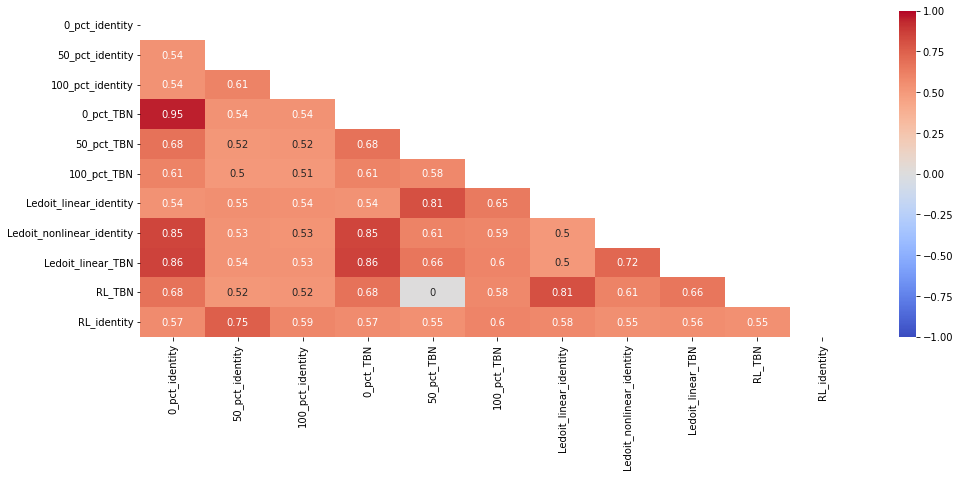

In [14]:
import seaborn as sns
plt.figure(figsize=(16, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(p_value_df, dtype=bool))
heatmap = sns.heatmap(p_value_df, mask=mask, vmin=-1, vmax=1, annot=True, cmap='coolwarm')

## Output

In [15]:
heatmap.figure.savefig('/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/picture/SR_p_value_heat.png')

In [18]:
p_value_df.to_latex('/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/output/SR_p_value_heat.tex', float_format = "%.3f")

# Portfolio Performance Matrices

## Turnover



In [5]:
def get_turnover_time_series_and_save_weight_df(strategy, strategy_name, write_csv = False):

    year_range = np.arange(2001, 2017+1)
    weight_list = [np.hstack(strategy.get_portfolio(year)) for year in year_range]
    weight_df = pd.DataFrame(weight_list, index=year_range)
    file_path = '/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/output/' + strategy_name + '.csv'
    if write_csv: weight_df.to_csv(file_path) 
    turnover_vector = weight_df.diff().abs().sum(axis=1)
    turnover_vector.iloc[0,] = weight_df.iloc[0,].abs().sum() # modify the first year turnover

    return turnover_vector

In [14]:
agent_dict = {'Ledoit_linear_identity': Linear_shrink_ledoit(),
            'Ledoit_nonlinear_identity': Nonlinear_shrink_ledoit(),
            'Ledoit_linear_TBN': Linear_shrink_tbn(),
            'RL_TBN': shrink_fixed_alpha_tbn(),
            'RL_identity': shrink_fixed_alpha_identity()
}

In [15]:
turnover_list = [get_turnover_time_series_and_save_weight_df(strategy, strategy_name) for strategy_name, strategy in agent_dict.items()]
turnover_df = pd.DataFrame(turnover_list, index=agent_dict.keys()).T

differential portfolios

In [16]:
file_1_path = '/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/output/Ledoit_linear_identity.csv'
file_2_path = '/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/output/Ledoit_nonlinear_identity.csv'
file_3_path = '/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/output/RL_identity.csv'
file_4_path = '/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/output/Ledoit_linear_TBN.csv'
file_5_path = '/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/output/RL_TBN.csv'

weight_1_df = pd.read_csv(file_1_path, index_col=0)
weight_2_df = pd.read_csv(file_2_path, index_col=0)
weight_3_df = pd.read_csv(file_3_path, index_col=0)
weight_4_df = pd.read_csv(file_4_path, index_col=0)
weight_5_df = pd.read_csv(file_5_path, index_col=0)

weight_6_df = weight_3_df - weight_1_df
weight_7_df = weight_3_df - weight_2_df
weight_8_df = weight_5_df - weight_4_df

weight_6_path = '/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/output/' + 'RL_identity-Ledoit_linear_identity' + '.csv'
weight_7_path = '/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/output/' + 'RL_identity-Ledoit_nonlinear_identity' + '.csv'
weight_8_path = '/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/output/' + 'RL_TBN-Ledoit_linear_TBN' + '.csv'

weight_6_df.to_csv(weight_6_path)
weight_7_df.to_csv(weight_7_path)
weight_8_df.to_csv(weight_8_path)

turnover_vector_6 = weight_6_df.diff().abs().sum(axis=1)
turnover_vector_7 = weight_7_df.diff().abs().sum(axis=1)
turnover_vector_8 = weight_8_df.diff().abs().sum(axis=1)

# modify the first year turnover
turnover_vector_6.iloc[0,] = weight_6_df.iloc[0,].abs().sum()
turnover_vector_7.iloc[0,] = weight_7_df.iloc[0,].abs().sum()
turnover_vector_8.iloc[0,] = weight_8_df.iloc[0,].abs().sum()

# combine 'diff' strategies to dataframe
turnover_df['RL_identity-Ledoit_linear_identity'] = turnover_vector_6
turnover_df['RL_identity-Ledoit_nonlinear_identity'] = turnover_vector_7
turnover_df['RL_TBN-Ledoit_linear_TBN'] = turnover_vector_8

In [17]:
turnover_df

,Ledoit_linear_identity,Ledoit_nonlinear_identity,Ledoit_linear_TBN,RL_TBN,RL_identity,RL_identity-Ledoit_linear_identity,RL_identity-Ledoit_nonlinear_identity,RL_TBN-Ledoit_linear_TBN
2001,1.068398,1.121237,1.084864,1.131492,1.131492,0.221673,0.204725,0.154749
2002,0.878858,0.901706,0.933475,0.809269,0.950385,1.142332,1.122227,0.570144
2003,1.447291,1.305145,1.486394,1.397364,0.008148,1.441484,1.299633,0.555700
2004,1.266553,1.117681,1.314971,1.406636,0.012660,1.266146,1.117120,0.112740
2005,1.662913,1.662991,1.816368,1.683307,0.000190,1.662780,1.662858,0.600360
2006,0.873507,0.924190,0.954554,0.626041,0.000068,0.873455,0.924140,0.679489
2007,0.921775,0.912370,0.968629,0.919236,0.000437,0.921531,0.912155,0.832605
2008,1.341263,1.313066,1.333335,0.816366,0.000682,1.340656,1.312532,0.704492
2009,1.688818,1.844698,1.745546,1.301525,0.005308,1.686046,1.841272,0.710429
2010,1.770800,1.794197,1.876041,1.213596,0.005658,1.769650,1.791530,0.833846


In [312]:
turnover_df.to_latex('/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/output/portfolios_turnover_df.tex', float_format="%.3f")

In [187]:
turnover_df.to_csv('/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/output/portfolios_turnover_df.csv')

## Transaction cost

\begin{equation}
p_{t}=\left(1+\tilde{p}_{t}\right)\left(1-c \times \text { Turnover }_{t-1}\right)-1
\end{equation}

In [105]:
portfolio_return_df = portfolio_return_df[agent_dict.keys()]


In [228]:
portfolio_return_annual_df = portfolio_return_df.groupby(pd.Grouper(freq="Y")).mean() * 252

In [280]:
def get_net_portfolio_return(year, transaction_cost = 20 * 0.01 * 0.01):
    c = transaction_cost
    portfolio_return_net_df = portfolio_return_df
    portfolio_return_net_df.loc[str(year)].iloc[0] = (1 + portfolio_return_df.loc[str(year)].iloc[0]) * (1 - c * turnover_df.loc[year]) - 1
    
    return portfolio_return_net_df.loc[str(year)]

In [282]:
portfolio_return_net_df = pd.concat([get_net_portfolio_return(year) for year in year_range])
portfolio_return_net_df

,Ledoit_linear_identity,Ledoit_nonlinear_identity,Ledoit_linear_TBN,RL_TBN,RL_identity
2001-01-02,-0.018192,-0.018453,-0.017119,-0.020145,-0.015350
2001-01-03,0.011468,0.009556,0.008355,0.010497,0.007000
2001-01-04,-0.010496,-0.010161,-0.010442,-0.012653,-0.009423
2001-01-05,-0.003127,-0.001237,-0.002310,-0.007006,0.000368
2001-01-08,-0.000062,0.000080,-0.000063,-0.000364,0.000154
...,...,...,...,...,...
2017-12-22,-0.002487,-0.002431,-0.002617,-0.001868,-0.001442
2017-12-26,-0.000338,-0.000048,-0.000365,0.001297,0.001117
2017-12-27,0.002075,0.002010,0.002229,0.001556,0.000662
2017-12-28,0.002453,0.002356,0.002392,0.001541,0.001744


In [283]:
portfolio_return_net_df.to_csv('/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/output/portfolio_return_net.csv')

## Performance matrices

In [27]:
mean_vec = portfolio_return_df.mean() * 252 * 100
std_vec = portfolio_return_df.std() * np.sqrt(252) 
skewness_vec = portfolio_return_df.skew()
kurtosis_vec = portfolio_return_df.kurtosis()

In [43]:
portfolio_performance_df = pd.concat([mean_vec, std_vec, skewness_vec, kurtosis_vec, SR_vec, TO_vec], axis=1).T
portfolio_performance_df.index = ['Mean', 'Standard deviation', 'Skewness', 'Kurtosis', 'Sharpe ratio', 'Turnover']
portfolio_performance_df

,0_pct_identity,50_pct_identity,100_pct_identity,0_pct_TBN,50_pct_TBN,100_pct_TBN,Ledoit_linear_identity,Ledoit_nonlinear_identity,Ledoit_linear_TBN,RL_TBN,RL_identity
Mean,6.878320,10.085880,10.894021,6.878320,7.233449,8.733032,7.095806,6.760061,6.851898,7.233449,10.162299
Standard deviation,0.141485,0.163922,0.173756,0.141485,0.138836,0.155159,0.140027,0.140173,0.140010,0.138836,0.170885
Skewness,0.449797,0.369507,0.350498,0.449797,0.578361,0.458887,0.485475,0.571034,0.471404,0.578361,0.370198
Kurtosis,10.161342,13.049700,11.492554,10.161342,14.660501,13.680747,10.819349,11.990603,10.842558,14.660501,12.128122
Sharpe ratio,0.577854,0.915915,0.934393,0.577854,0.706204,0.806761,0.622106,0.593815,0.598130,0.706204,0.864733
Turnover,0.845000,0.067000,0.000000,0.845000,0.410000,0.167000,0.726000,0.717000,0.770000,0.485000,0.294000


In [54]:
portfolio_performance_df.iloc[:, 6:].to_latex('/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/output/port_performance_matrices.tex', float_format = "%.3f")

# Stacked Area Chart

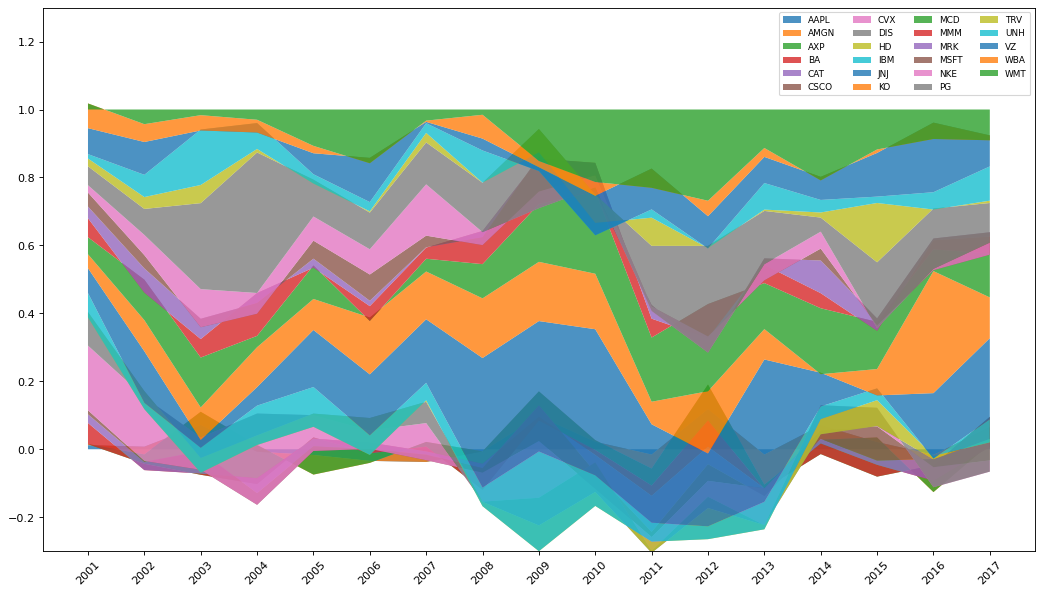

In [313]:
# load data
strategy_name_vec = ['Ledoit_linear_identity',
                    'Ledoit_linear_TBN',
                    'Ledoit_nonlinear_identity',
                    'RL_TBN', 
                    'RL_identity',
                    'RL_identity-Ledoit_linear_identity',
                    'RL_identity-Ledoit_nonlinear_identity',
                    'RL_TBN-Ledoit_linear_TBN']
strategy_name = strategy_name_vec[0]
file_path = '../../output/' + strategy_name + '.csv'
portfolio_weight = pd.read_csv(file_path, index_col=0)
agent_test = Shrink_100_tbn()
stock_symbols = agent_test.stocks_returns_aggregate.columns.values

# Draw Plot and Annotate
fig, ax = plt.subplots(1,1,figsize=(16, 9), dpi= 80)
ax = plt.gca()
ax.stackplot(portfolio_weight.index, portfolio_weight.T,labels=stock_symbols, alpha=0.8)

# Decorations
ax.set(ylim=[-0.3, 1.3])
ax.legend(fontsize=8, ncol=4)
plt.xticks(np.arange(2001, 2018), fontsize=10,rotation = 45, horizontalalignment='center')

plt.show()
fig.savefig('/Users/cheng/Google Drive/PhD/Research/Portfolio Selection via TBN/output/figure/' + strategy_name + '_stackplot.png')

# Herfindahl-Hirschman Index (HHI)

In [2]:
def get_HHI_mean_for_portfolio_ts(portfolio_weight_df):
    HHI = ((portfolio_weight_df * 1) ** 2).sum(axis=1).mean()
    return HHI

In [3]:
# 
strategy_name_vec = ['Ledoit_linear_identity',
                    'Ledoit_linear_TBN',
                    'Ledoit_nonlinear_identity',
                    'RL_TBN', 
                    'RL_identity',
                    'RL_identity-Ledoit_linear_identity',
                    'RL_identity-Ledoit_nonlinear_identity',
                    'RL_TBN-Ledoit_linear_TBN']
                    
# calculate HHI
file_path_vec = ['../../output/' + strategy_name + '.csv' for strategy_name in strategy_name_vec]
portfolio_weight_vec = [pd.read_csv(file_path, index_col=0) for file_path in file_path_vec]
HHI_vec = [get_HHI_mean_for_portfolio_ts(portfolio_weight) for portfolio_weight in portfolio_weight_vec]
HHI_series = pd.Series(HHI_vec, index = strategy_name_vec)

In [18]:
strategy_name_vec_reoder = ['Ledoit_linear_identity',
                    'Ledoit_nonlinear_identity',
                    'RL_identity',
                    'Ledoit_linear_TBN',
                    'RL_TBN', 
                    'RL_identity-Ledoit_linear_identity',
                    'RL_identity-Ledoit_nonlinear_identity',
                    'RL_TBN-Ledoit_linear_TBN']

# combine HHI and turnover into df
portfolio_stability_df = pd.DataFrame([HHI_series, turnover_df.mean()], index=['HHI', 'Turnover'])
portfolio_stability_df[strategy_name_vec_reoder]

,Ledoit_linear_identity,Ledoit_nonlinear_identity,RL_identity,Ledoit_linear_TBN,RL_TBN,RL_identity-Ledoit_linear_identity,RL_identity-Ledoit_nonlinear_identity,RL_TBN-Ledoit_linear_TBN
HHI,0.236924,0.238559,0.072054,0.271586,0.168287,0.170213,0.173092,0.051062
Turnover,1.430026,1.416477,0.418662,1.514521,1.063199,1.392892,1.386144,0.841148


In [341]:
portfolio_stability_df[strategy_name_vec_reoder].to_latex('../../output/portfolio_stability_df.tex', float_format="%.3f")